In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tools
%load_ext autoreload
%autoreload 2

## Description
Contextualised as such
- I am option seller
- I sold put (to investors who want to protect downside in a bull market, eg. index options)
- Short put = positive delta
- I hedge by getting exposure to negative delta, aka short underlying
- Therefore I am in a reverse of protective put (short put, short stock) -> farm premium

## Global variables

In [2]:
np.random.seed(42)

S0 = 100      # initial stock price
mu = 0.05    # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
T = 1         # maturity
n_steps = 24  # number of time steps
N_MC = 10000  # number of paths
K = 100
option_type = 'put'

dt = T / n_steps          # time interval
gamma = np.exp(- r * dt)  # discount factor

preview_idx = 5

risk_lambda = 0.001  # risk aversion
reg_param = 1e-3     # free parameter

## Generate MC stock prices

In [3]:
S, delta_S, delta_S_hat, X = tools.get_stock_prices(S0, N_MC, T, n_steps, mu, sigma, r)

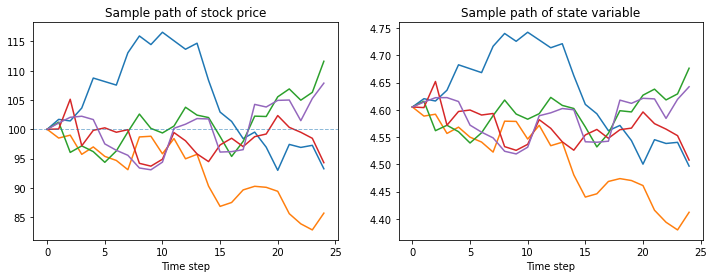

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(S.loc[:preview_idx,:].T)
ax[0].set_xlabel('Time step')
ax[0].set_title('Sample path of stock price')
ax[0].axhline(y=100, ls='--', linewidth=1, alpha=0.5)

ax[1].plot(X.loc[:preview_idx,:].T)
ax[1].set_xlabel('Time step')
ax[1].set_title('Sample path of state variable')
plt.show()

## Set splines and basis functions

X.shape (10000, 25)
X_min 4.025
X_max 5.191


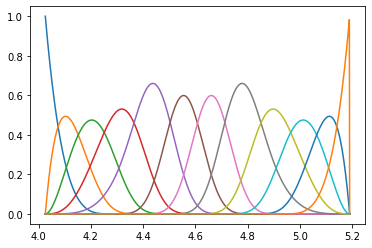

In [5]:
basis = tools.get_basis(X)

In [6]:
data_mat_t = tools.get_data_from_splines(X, basis, n_steps, N_MC)

num_basis 12
dim data_mat_t (25, 10000, 12)
Computational time 27.25s



## Get optimal hedge and portfolio

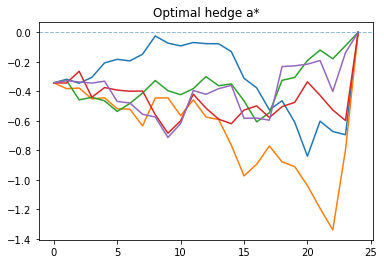

In [7]:
a, Pi, Pi_hat = tools.get_pi_and_opt_hedge(
    delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type,
)
plt.plot(a.loc[:preview_idx,].T)
plt.axhline(y=0, ls='--', alpha=0.5, linewidth=1)
plt.title('Optimal hedge a*')
plt.show()

## Get rewards

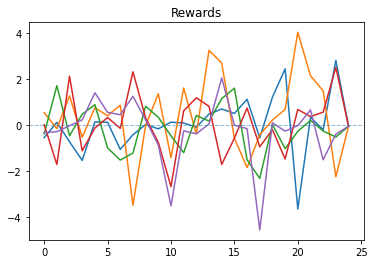

In [8]:
rewards = tools.get_rewards(Pi, a, delta_S, n_steps, risk_lambda, gamma)
plt.plot(rewards.loc[:preview_idx,].T)
plt.axhline(y=0, ls='--', alpha=0.5, linewidth=1)
plt.title('Rewards')
plt.show()

## Get Q function

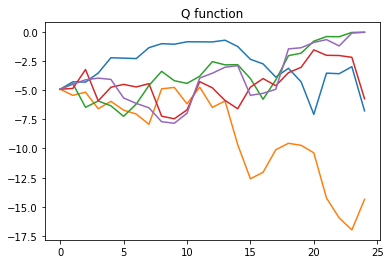

In [9]:
Q = tools.get_q_function(
    data_mat_t, rewards, Pi,
    reg_param, gamma, n_steps, risk_lambda,
)
c_qlbs = -Q.copy()
plt.plot(Q.loc[:preview_idx,].T)
plt.title('Q function')
plt.show()

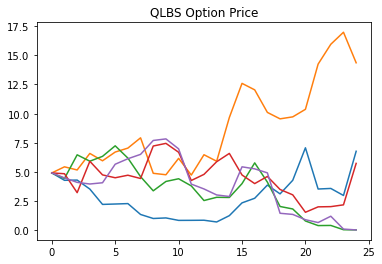

In [10]:
plt.plot(c_qlbs.loc[:preview_idx,].T)
plt.title('QLBS Option Price')
plt.show()

## Get BSM data

In [11]:
bsm_delta = tools.get_df_delta(S, K, r, sigma, T, option_type, N_MC, n_steps)
bsm_price = tools.get_df_bsm_prices(S, K, r, sigma, T, option_type, N_MC, n_steps)

## Option prices

In [12]:
ts = [0, 6, 12, 18, 23, 24]

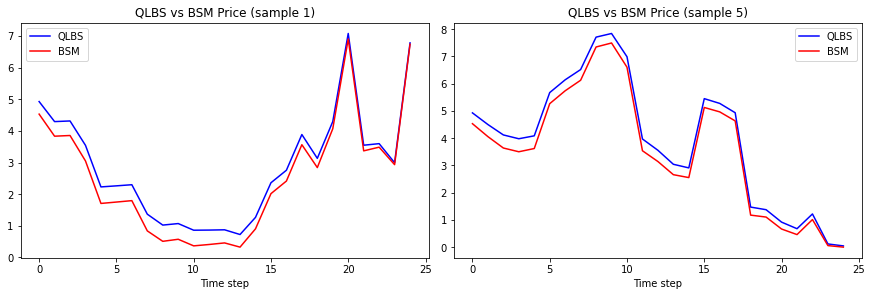

In [13]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_idx = [1, 5]

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(c_qlbs.loc[idx,:], label='QLBS', color='blue')
    p1, = ax[i].plot(bsm_price.loc[idx,:], label='BSM', color='red')
    ax[i].set_title(f'QLBS vs BSM Price (sample {idx})')
    ax[i].legend(handles=[p0, p1], loc='best')
    ax[i].set_xlabel('Time step')

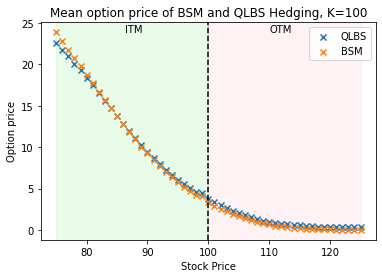

In [14]:
tools.plot_mean_curve(S, K, c_qlbs, bsm_price, option_type, 'option')

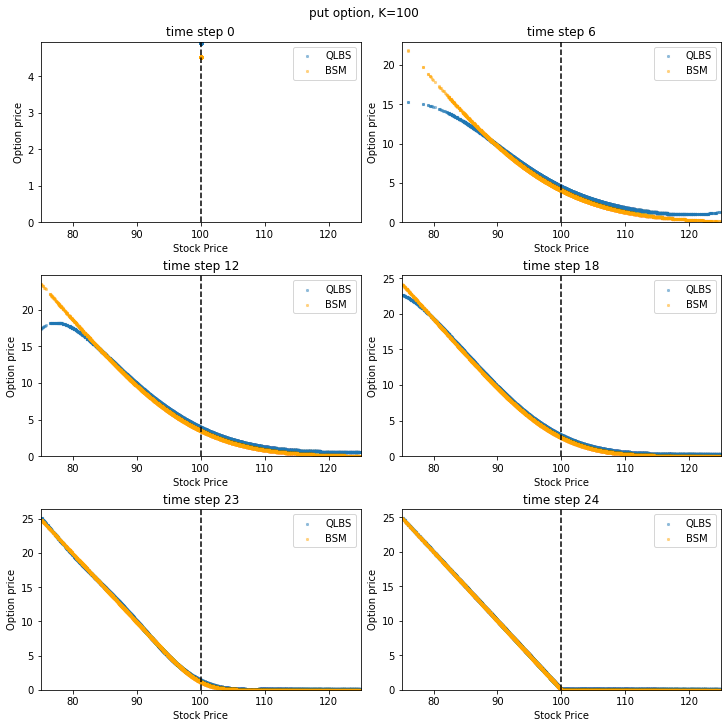

In [15]:
tools.plot_time_curve(S, K, c_qlbs, bsm_price, option_type, 'option', ts=ts)

In [16]:
print('-------------------------------')
print('      QLBS vs BSM Pricing      ')
print('-------------------------------\n')
print('%-25s' % ('Initial Stock Price:'), S0)
print('%-25s' % ('Drift of Stock:'), mu)
print('%-25s' % ('Volatility of Stock:'), sigma)
print('%-25s' % ('Risk-free Rate:'), r)
print('%-25s' % ('Risk aversion parameter: '), risk_lambda)
print('%-25s' % ('Strike:'), K)
print('%-25s' % ('Maturity:'), T)
print('%-25s' % ('Option type:'), option_type)
print('%-26s %.3f' % ('\nQLBS Price: ', c_qlbs.iloc[0,0]))
print('%-25s %.3f' % ('Black-Scholes Price:', bsm_price.iloc[0,0]))

-------------------------------
      QLBS vs BSM Pricing      
-------------------------------

Initial Stock Price:      100
Drift of Stock:           0.05
Volatility of Stock:      0.15
Risk-free Rate:           0.03
Risk aversion parameter:  0.001
Strike:                   100
Maturity:                 1
Option type:              put

QLBS Price:               4.926
Black-Scholes Price:      4.530


## Delta curves

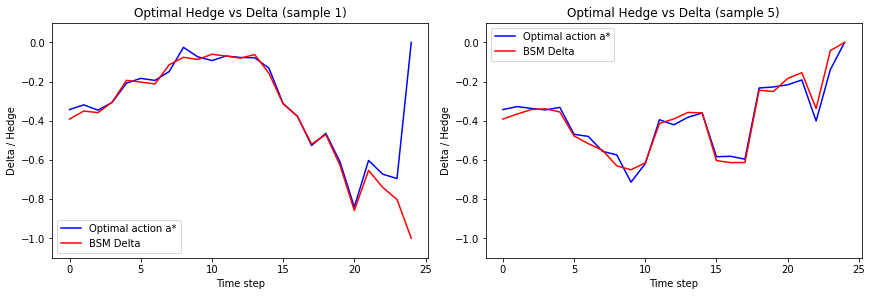

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(a.loc[idx,:], label='Optimal action a*', color='blue')
    p1, = ax[i].plot(bsm_delta.loc[idx,:], label='BSM Delta', color='red')
    ax[i].set_title(f'Optimal Hedge vs Delta (sample {idx})')
    ax[i].set_ylabel('Delta / Hedge')
    ax[i].legend(handles=[p0, p1], loc='best')
    ax[i].set_xlabel('Time step')
    if option_type=='call':
        ax[i].set_ylim([-0.1, 1.1])
    else:
        ax[i].set_ylim([-1.1, 0.1])

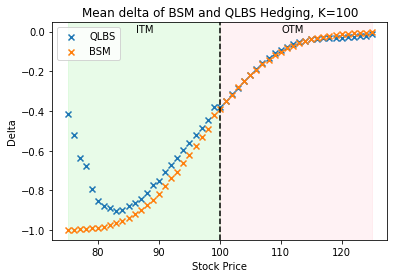

In [18]:
tools.plot_mean_curve(S, K, a, bsm_delta, option_type, 'delta')

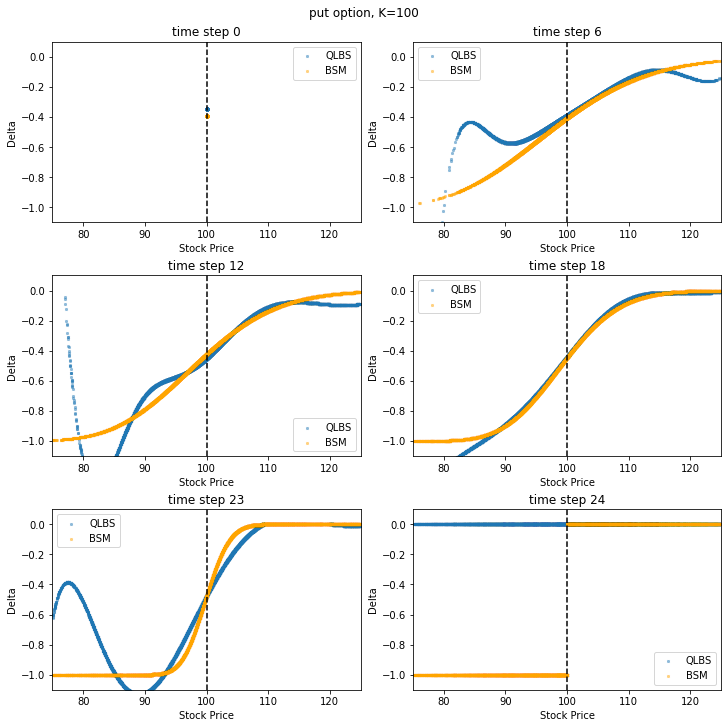

In [19]:
tools.plot_time_curve(S, K, a, bsm_delta, option_type, 'delta', ts=ts)

In [20]:
counts = {'lower': [], 'upper': [], 'mean':[]}
for t in ts:
    tmp = S[t]
    counts['lower'].append(tmp[tmp < 90].shape[0]/N_MC)
    counts['upper'].append(tmp[tmp > 110].shape[0]/N_MC)
    counts['mean'].append(tmp.mean())
pd.DataFrame(data=counts, index=ts)

,lower,upper,mean
0,0.0000,0.0000,100.000000
6,0.0621,0.1254,101.213313
12,0.1236,0.2342,102.560210
18,0.1475,0.3073,103.875508
23,0.1653,0.3476,104.978188
24,0.1728,0.3584,105.216564


## Compare PnL

In [21]:
## our position: short put, short underlying
## short put: +ve delta
## short underlying: -ve delta
## + initial option premium - final payoff + hedging pnl

bs_hedging_pnl = -tools.get_pnl(S, bsm_delta, n_steps)
q_hedging_pnl = -tools.get_pnl(S, a, n_steps)

q_option_pnl = c_qlbs.iloc[0,0] - c_qlbs[n_steps]
bs_option_pnl = bsm_price.iloc[0,0] -bsm_price[n_steps]

q_final_pnl = q_option_pnl + q_hedging_pnl.sum(axis=1)
bs_final_pnl = bs_option_pnl + bs_hedging_pnl.sum(axis=1)

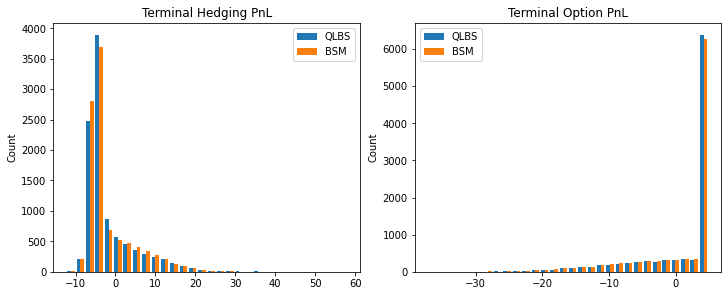

In [22]:
bins = 30

f, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax[0].hist([q_hedging_pnl.sum(axis=1), bs_hedging_pnl.sum(axis=1)], bins=bins, label=['QLBS', 'BSM'])
ax[0].legend()
ax[0].set_title('Terminal Hedging PnL')
ax[0].set_ylabel('Count')
ax[1].hist([q_option_pnl, bs_option_pnl], bins=bins, label=['QLBS', 'BSM'])
ax[1].legend()
ax[1].set_title('Terminal Option PnL')
ax[1].set_ylabel('Count')
plt.show()

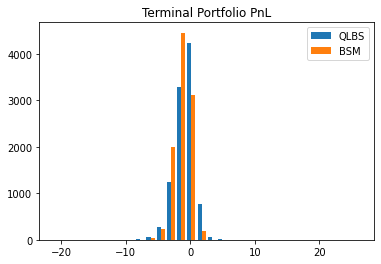

In [23]:
plt.hist([q_final_pnl, bs_final_pnl], label=['QLBS', 'BSM'], bins=bins)
plt.legend()
plt.title('Terminal Portfolio PnL')
plt.show()

In [24]:
pd.DataFrame({
    'QLBS (mean)': [q_hedging_pnl.sum(axis=1).mean(), q_option_pnl.mean(), q_final_pnl.mean()],
    'BSM (mean)': [bs_hedging_pnl.sum(axis=1).mean(), bs_option_pnl.mean(), bs_final_pnl.mean()],
    'QLBS (std)': [q_hedging_pnl.sum(axis=1).std(), q_option_pnl.std(), q_final_pnl.std()],
    'BSM (std)': [bs_hedging_pnl.sum(axis=1).std(), bs_option_pnl.std(), bs_final_pnl.std()]
}, index=['Hedging', 'Option', 'Portfolio (Total)']).round(2)

,QLBS (mean),BSM (mean),QLBS (std),BSM (std)
Hedging,-1.69,-1.85,6.36,6.15
Option,0.94,0.59,6.66,6.66
Portfolio (Total),-0.75,-1.27,1.72,1.22


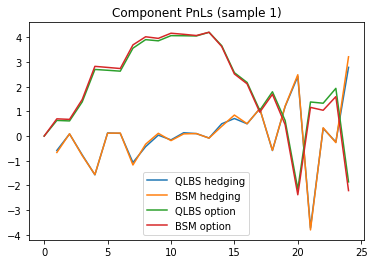

In [25]:
idx = 1
plt.plot(q_hedging_pnl.loc[idx,], label='QLBS hedging')
plt.plot(bs_hedging_pnl.loc[idx,], label='BSM hedging')
plt.plot(-c_qlbs.loc[idx,] + c_qlbs.iloc[0,0], label='QLBS option')
plt.plot(-bsm_price.loc[idx,] + bsm_price.iloc[0,0], label='BSM option')
plt.title(f'Component PnLs (sample {idx})')
plt.legend()
plt.show()

## perform some statistical test
- compare mean: t test
- compare stdev: f test

In [26]:
from scipy import stats

In [27]:
# 1. Perform a t-test to compare the means
t_stat, p_value_t = stats.ttest_ind(q_final_pnl, bs_final_pnl)

# 2. Perform an F-test to compare the variances
f_stat = np.var(q_final_pnl, ddof=1) / np.var(bs_final_pnl, ddof=1)  # F-statistic
dof1 = len(q_final_pnl) - 1 
dof2 = len(bs_final_pnl) - 1 
p_value_f = 1 - stats.f.cdf(f_stat, dof1, dof2)  # Right-tailed p-value

alpha = 0.05
print(f'\nSignificance level: {alpha}\n')
print('T-test')
print('Null hypothesis: there is a significant difference between the means of two groups')
print(f'T stat\t{t_stat:.3f}')
print(f'P value\t{p_value_t:.3f}')
if p_value_t < alpha:
    print('Reject null hypothesis')
else:
    print('Not reject null hypothesis')
print(f'\nF-test')
print('Null hypothesis: there is a significant difference between the variance of two groups')
print(f'F stat\t{f_stat:.3f}')
print(f'P value\t{p_value_f:.3f}')
if p_value_f < alpha:
    print('Reject null hypothesis')
else:
    print('Not reject null hypothesis')


Significance level: 0.05

T-test
Null hypothesis: there is a significant difference between the means of two groups
T stat	24.363
P value	0.000
Reject null hypothesis

F-test
Null hypothesis: there is a significant difference between the variance of two groups
F stat	1.967
P value	0.000
Reject null hypothesis


## Risk lambda

In [28]:
risk_lambdas = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0, ]
risk_deltas, risk_prices, risk_pis = tools.vary_risk_lambda(
    risk_lambdas, delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type,
)

lambda	time
------	----
0.01	0.14s
0.005	0.14s
0.001	0.13s
0.0005	0.14s
0.0001	0.13s
0	0.18s


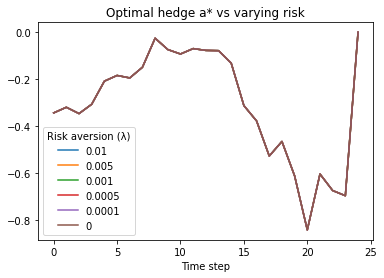

In [29]:
for risk_lam in risk_lambdas:
    plt.plot(risk_deltas[risk_lam].iloc[0], label=risk_lam)
plt.legend(title='Risk aversion (λ)')
plt.title('Optimal hedge a* vs varying risk')
plt.xlabel('Time step')
plt.show()

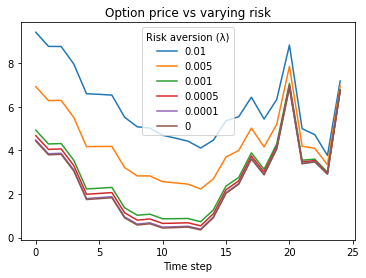

In [30]:
for risk_lam in risk_lambdas:
    plt.plot(risk_prices[risk_lam].iloc[0], label=risk_lam)
plt.legend(title='Risk aversion (λ)')
plt.title('Option price vs varying risk')
plt.xlabel('Time step')
plt.show()

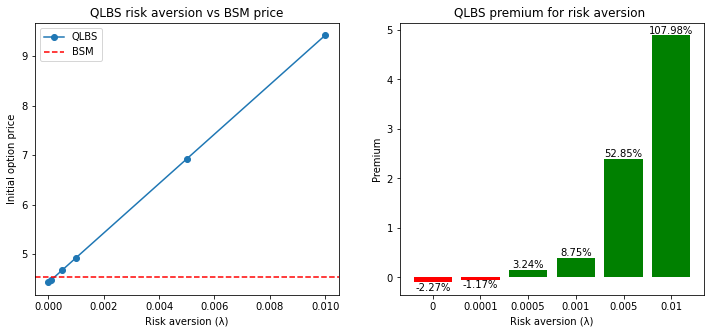

In [31]:
risk_means = [risk_prices[rl][0].mean() for rl in risk_lambdas]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].plot(risk_lambdas, risk_means, marker='o', label='QLBS')
ax[0].axhline(y=bsm_price.iloc[0,0], color='red', ls='--', label='BSM')
ax[0].set_xlabel('Risk aversion (λ)')
ax[0].set_ylabel('Initial option price')
ax[0].set_title('QLBS risk aversion vs BSM price')
ax[0].legend()

premiums = [j-bsm_price.iloc[0,0] for j in risk_means[::-1]]
colors = ['g' if p >= 0 else 'r' for p in premiums]
container = ax[1].bar([str(i) for i in risk_lambdas[::-1]], premiums, color=colors)
ax[1].set_xlabel('Risk aversion (λ)')
ax[1].set_ylabel('Premium')
ax[1].set_title('QLBS premium for risk aversion ')
ax[1].bar_label(container, fmt=lambda x: f'{x/bsm_price.iloc[0,0]*100:.2f}%')
plt.show()

In [100]:
hedging_pnls = {}
option_pnls = {}
final_pnls = {}

for rl in risk_lambdas:
    hedging_pnls[rl] = -tools.get_pnl(S, risk_deltas[rl], n_steps)
    option_pnls[rl] = risk_prices[rl].iloc[0,0] - risk_prices[rl][n_steps]
    final_pnls[rl] = hedging_pnls[rl].sum(axis=1) + option_pnls[rl]

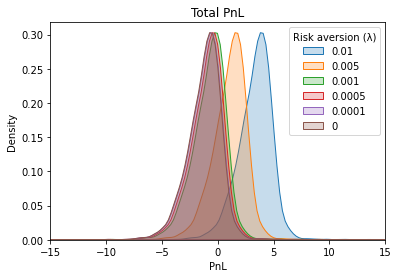

In [103]:
plot_pnls_means = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])
plot_pnls_stds = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])

# print('eps\ttotal\toption\thedging')
# print('---\t-----\t------\t-------')
for rl in risk_lambdas:
    sns.kdeplot(final_pnls[rl], shade=True, label=rl)
    plot_pnls_means.loc[rl,] = [
        final_pnls[rl].mean(), 
        option_pnls[rl].mean(),
        hedging_pnls[rl].sum(axis=1).mean()
    ]
    plot_pnls_stds.loc[rl,] = [
        final_pnls[rl].std(), 
        option_pnls[rl].std(),
        hedging_pnls[rl].sum(axis=1).std()
    ]
#     print(f'{eps}\t{final_pnls[eps].mean():.3f}\t{option_pnls[eps].mean():.3f}\t{hedging_pnls[eps].sum(axis=1).mean():.3f}')
plt.legend(title='Risk aversion (λ)')
plt.title('Total PnL')
plt.xlim([-15, 15])
plt.xlabel('PnL')
plt.show()

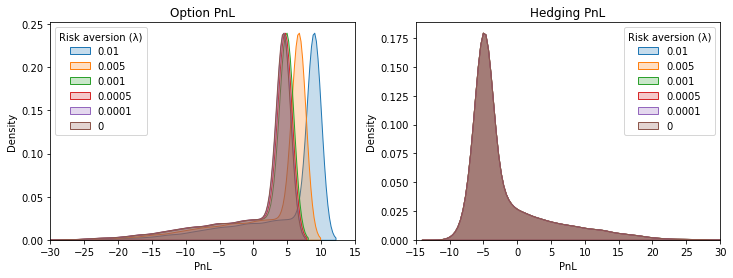

In [110]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for rl in risk_lambdas:
    sns.kdeplot(option_pnls[rl], shade=True, label=rl, ax=ax[0])
    sns.kdeplot(hedging_pnls[rl].sum(axis=1), shade=True, label=rl, ax=ax[1])
ax[0].legend(title='Risk aversion (λ)')
ax[0].set_title('Option PnL')
ax[0].set_xlim([-30, 15])
ax[0].set_xlabel('PnL')
ax[1].legend(title='Risk aversion (λ)')
ax[1].set_title('Hedging PnL')
ax[1].set_xlim([-15, 30])
ax[1].set_xlabel('PnL')
plt.show()

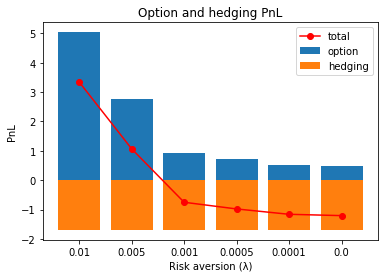

In [106]:
for col in plot_pnls_means[['option', 'hedging']]:
    plt.bar([str(i) for i in plot_pnls_means.index], plot_pnls_means[col], label=col)
plt.plot([str(i) for i in plot_pnls_means.index], plot_pnls_means.total, color='red', marker='o', label='total')
plt.legend()
plt.title('Option and hedging PnL')
plt.xlabel('Risk aversion (λ)')
plt.ylabel('PnL')
plt.show()

In [107]:
plot_pnls_stds.astype(float).round(2)

,total,option,hedging
0.0100,1.72,6.66,6.36
0.0050,1.72,6.66,6.36
0.0010,1.72,6.66,6.36
0.0005,1.72,6.66,6.36
0.0001,1.72,6.66,6.36
0.0000,1.72,6.66,6.36


In [108]:
plot_pnls_means.astype(float).round(2)

,total,option,hedging
0.0100,3.34,5.04,-1.69
0.0050,1.07,2.76,-1.69
0.0010,-0.75,0.94,-1.69
0.0005,-0.98,0.71,-1.69
0.0001,-1.16,0.53,-1.69
0.0000,-1.21,0.49,-1.69


## Linear Transaction cost

In [32]:
epsilons = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0, ]
eps_deltas, eps_prices = tools.vary_txn_cost(
    epsilons, delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type, kolm=False
)

epsilon	time
-------	----
0.01	0.21s
0.005	0.21s
0.001	0.16s
0.0005	0.16s
0.0001	0.19s
0	0.33s


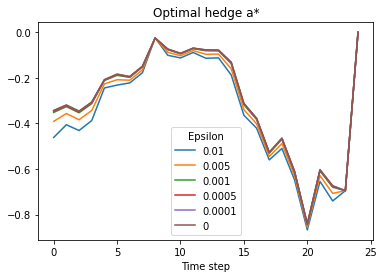

In [33]:
for eps in epsilons:
    plt.plot(eps_deltas[eps].iloc[0], label=eps)
plt.legend(title='Epsilon')
plt.title('Optimal hedge a*')
plt.xlabel('Time step')
plt.show()

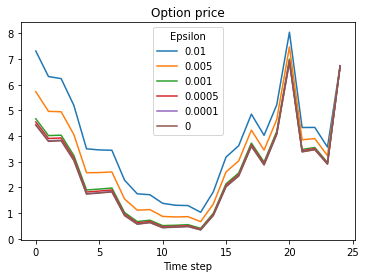

In [34]:
for eps in epsilons:
    plt.plot(eps_prices[eps].iloc[0], label=eps)
plt.legend(title='Epsilon')
plt.title('Option price')
plt.xlabel('Time step')
plt.show()

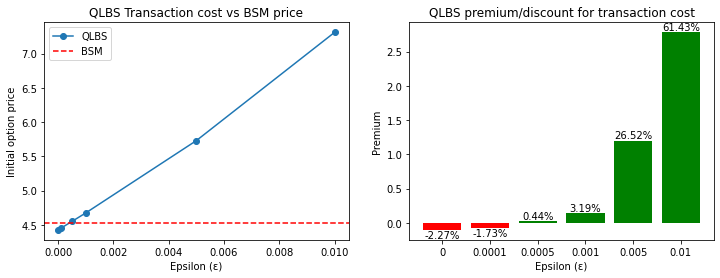

In [35]:
eps_means = [eps_prices[eps].iloc[0,0] for eps in epsilons]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(epsilons, eps_means, marker='o', label='QLBS')
ax[0].axhline(y=bsm_price.iloc[0,0], color='red', ls='--', label='BSM')
ax[0].set_xlabel('Epsilon (ε)')
ax[0].set_ylabel('Initial option price')
ax[0].set_title('QLBS Transaction cost vs BSM price')
ax[0].legend()

premiums = [j-bsm_price.iloc[0,0] for j in eps_means[::-1]]
colors = ['g' if p >= 0 else 'r' for p in premiums]
container = ax[1].bar([str(i) for i in epsilons[::-1]], premiums, color=colors)
ax[1].set_xlabel('Epsilon (ε)')
ax[1].set_ylabel('Premium')
ax[1].set_title('QLBS premium/discount for transaction cost')
ax[1].bar_label(container, fmt=lambda x: f'{x/bsm_price.iloc[0,0]*100:.2f}%')
plt.show()

In [36]:
eps_plot = np.arange(0, 0.025, 0.0001)
eps_deltas_plot, eps_prices_plot = tools.vary_txn_cost(
    eps_plot, delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type, print_line=False
)

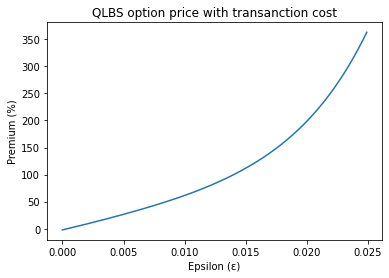

In [37]:
eps_means_plot = [eps_prices_plot[eps].iloc[0,0] for eps in eps_plot]
premiums = [(j-bsm_price.iloc[0,0])/bsm_price.iloc[0,0]*100 for j in eps_means_plot]
plt.plot(eps_plot, premiums)
plt.xlabel('Epsilon (ε)')
plt.ylabel('Premium (%)')
plt.title('QLBS option price with transanction cost')
plt.show()

In [38]:
hedging_pnls = {}
option_pnls = {}
final_pnls = {}

for eps in epsilons:
    hedging_pnls[eps] = -tools.get_pnl(S, eps_deltas[eps], n_steps)
    option_pnls[eps] = eps_prices[eps].iloc[0,0] - eps_prices[eps][n_steps]
    final_pnls[eps] = hedging_pnls[eps].sum(axis=1) + option_pnls[eps]

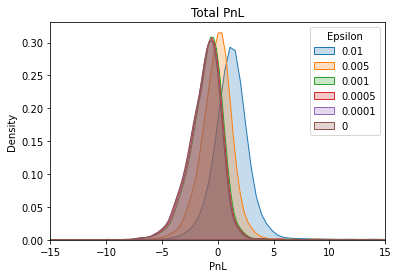

In [39]:
plot_pnls_means = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])
plot_pnls_stds = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])

# print('eps\ttotal\toption\thedging')
# print('---\t-----\t------\t-------')
for eps in epsilons:
    sns.kdeplot(final_pnls[eps], shade=True, label=eps)
    plot_pnls_means.loc[eps,] = [
        final_pnls[eps].mean(), 
        option_pnls[eps].mean(),
        hedging_pnls[eps].sum(axis=1).mean()
    ]
    plot_pnls_stds.loc[eps,] = [
        final_pnls[eps].std(), 
        option_pnls[eps].std(),
        hedging_pnls[eps].sum(axis=1).std()
    ]
#     print(f'{eps}\t{final_pnls[eps].mean():.3f}\t{option_pnls[eps].mean():.3f}\t{hedging_pnls[eps].sum(axis=1).mean():.3f}')
plt.legend(title='Epsilon')
plt.title('Total PnL')
plt.xlim([-15, 15])
plt.xlabel('PnL')
plt.show()

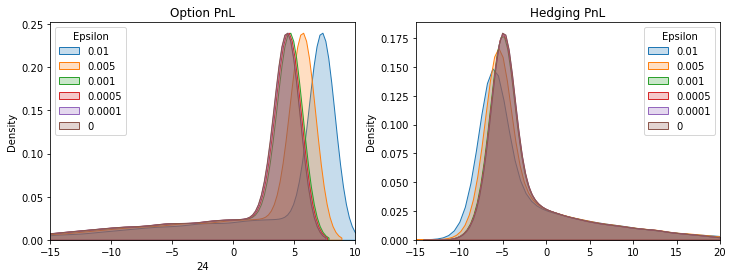

In [40]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for eps in epsilons:
    sns.kdeplot(option_pnls[eps], shade=True, label=eps, ax=ax[0])
    sns.kdeplot(hedging_pnls[eps].sum(axis=1), shade=True, label=eps, ax=ax[1])
ax[0].legend(title='Epsilon')
ax[0].set_title('Option PnL')
ax[0].set_xlim([-15, 10])
ax[1].legend(title='Epsilon')
ax[1].set_title('Hedging PnL')
ax[1].set_xlim([-15, 20])
plt.show()

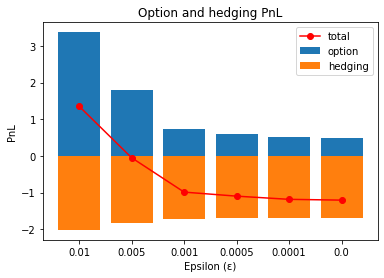

In [41]:
for col in plot_pnls_means[['option', 'hedging']]:
    plt.bar([str(i) for i in plot_pnls_means.index], plot_pnls_means[col], label=col)
plt.plot([str(i) for i in plot_pnls_means.index], plot_pnls_means.total, color='red', marker='o', label='total')
plt.legend()
plt.title('Option and hedging PnL')
plt.xlabel('Epsilon (ε)')
plt.ylabel('PnL')
plt.show()

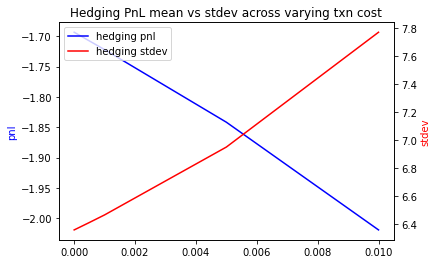

In [42]:
f, ax = plt.subplots()
a1, = ax.plot(plot_pnls_means.hedging, label='hedging pnl', color='blue')
ax.set_ylabel('pnl', color='blue')
ax2 = ax.twinx()
a2, = ax2.plot(plot_pnls_stds.hedging, label='hedging stdev', color='red')
ax2.set_ylabel('stdev', color='red')
plt.legend(handles=[a1, a2], loc='best')
plt.title('Hedging PnL mean vs stdev across varying txn cost')
plt.xlabel('Epsilon (ε)')
plt.show()

In [43]:
plot_pnls_stds.astype(float).round(2)

,total,option,hedging
0.0100,2.69,6.66,7.77
0.0050,1.94,6.66,6.95
0.0010,1.72,6.66,6.47
0.0005,1.72,6.66,6.41
0.0001,1.72,6.66,6.37
0.0000,1.72,6.66,6.36


In [44]:
plot_pnls_means.astype(float).round(2)

,total,option,hedging
0.0100,1.35,3.37,-2.02
0.0050,-0.05,1.79,-1.84
0.0010,-0.99,0.73,-1.72
0.0005,-1.10,0.61,-1.71
0.0001,-1.19,0.51,-1.70
0.0000,-1.21,0.49,-1.69


## Txn + Market impact cost (Kolm, squared)

In [45]:
epsilons = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0, ]
eps_k_deltas, eps_k_prices = tools.vary_txn_cost(
    epsilons, delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type, kolm=True
)

epsilon	time
-------	----
0.01	0.29s
0.005	0.17s
0.001	0.19s
0.0005	0.29s
0.0001	0.37s
0	0.21s


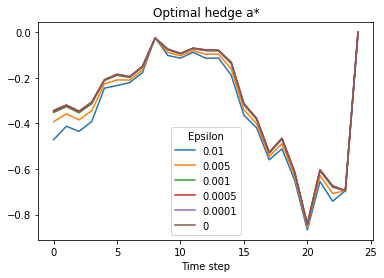

In [46]:
for eps in epsilons:
    plt.plot(eps_k_deltas[eps].iloc[0], label=eps)
plt.legend(title='Epsilon')
plt.title('Optimal hedge a*')
plt.xlabel('Time step')
plt.show()

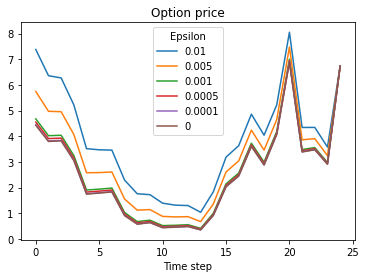

In [47]:
for eps in epsilons:
    plt.plot(eps_k_prices[eps].iloc[0], label=eps)
plt.legend(title='Epsilon')
plt.title('Option price')
plt.xlabel('Time step')
plt.show()

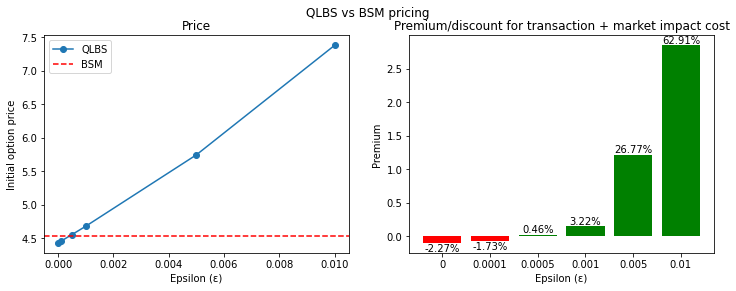

In [48]:
eps_k_means = [eps_k_prices[eps].iloc[0,0] for eps in epsilons]
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(epsilons, eps_k_means, marker='o', label='QLBS')
ax[0].axhline(y=bsm_price.iloc[0,0], color='red', ls='--', label='BSM')
ax[0].set_xlabel('Epsilon (ε)')
ax[0].set_ylabel('Initial option price')
ax[0].set_title('Price')
ax[0].legend()

premiums = [j-bsm_price.iloc[0,0] for j in eps_k_means[::-1]]
colors = ['g' if p >= 0 else 'r' for p in premiums]
container = ax[1].bar([str(i) for i in epsilons[::-1]], premiums, color=colors)
ax[1].set_xlabel('Epsilon (ε)')
ax[1].set_ylabel('Premium')
ax[1].set_title('Premium/discount for transaction + market impact cost')
ax[1].bar_label(container, fmt=lambda x: f'{x/bsm_price.iloc[0,0]*100:.2f}%')

plt.suptitle('QLBS vs BSM pricing')
plt.show()

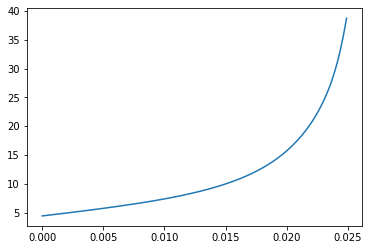

In [49]:
eps_plot = np.arange(0, 0.025, 0.0001)
eps_deltas_k_plot, eps_prices_k_plot = tools.vary_txn_cost(
    eps_plot, delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type, print_line=False, kolm=True
)
eps_means_k_plot = [eps_prices_k_plot[eps].iloc[0,0] for eps in eps_plot]
premiums = [j-bsm_price.iloc[0,0] for j in eps_means_k_plot[::-1]]
plt.plot(eps_plot, eps_means_k_plot)
plt.show()

In [50]:
hedging_pnls = {}
option_pnls = {}
final_pnls = {}

for eps in epsilons:
    hedging_pnls[eps] = -tools.get_pnl(S, eps_k_deltas[eps], n_steps)
    option_pnls[eps] = eps_k_prices[eps].iloc[0,0] - eps_k_prices[eps][n_steps]
    final_pnls[eps] = hedging_pnls[eps].sum(axis=1) + option_pnls[eps]

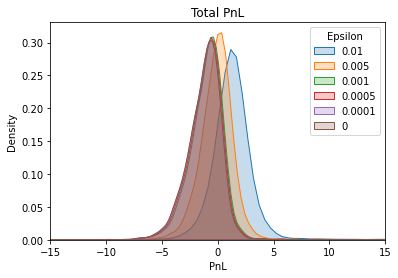

In [51]:
plot_pnls_means = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])
plot_pnls_stds = pd.DataFrame(index=epsilons, columns=['total', 'option', 'hedging'])

# print('eps\ttotal\toption\thedging')
# print('---\t-----\t------\t-------')
for eps in epsilons:
    sns.kdeplot(final_pnls[eps], shade=True, label=eps)
    plot_pnls_means.loc[eps,] = [
        final_pnls[eps].mean(), 
        option_pnls[eps].mean(),
        hedging_pnls[eps].sum(axis=1).mean()
    ]
    plot_pnls_stds.loc[eps,] = [
        final_pnls[eps].std(), 
        option_pnls[eps].std(),
        hedging_pnls[eps].sum(axis=1).std()
    ]
#     print(f'{eps}\t{final_pnls[eps].mean():.3f}\t{option_pnls[eps].mean():.3f}\t{hedging_pnls[eps].sum(axis=1).mean():.3f}')
plt.legend(title='Epsilon')
plt.title('Total PnL')
plt.xlim([-15, 15])
plt.xlabel('PnL')
plt.show()

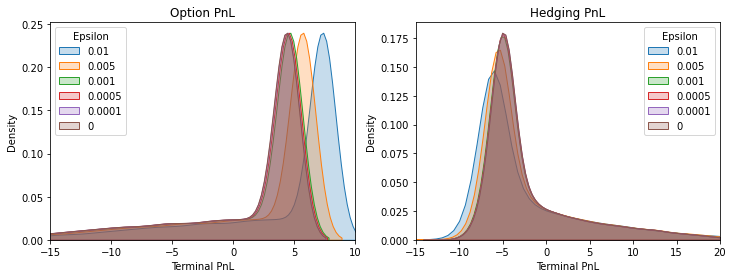

In [52]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for eps in epsilons:
    sns.kdeplot(option_pnls[eps], shade=True, label=eps, ax=ax[0])
    sns.kdeplot(hedging_pnls[eps].sum(axis=1), shade=True, label=eps, ax=ax[1])
ax[0].legend(title='Epsilon')
ax[0].set_title('Option PnL')
ax[0].set_xlim([-15, 10])
ax[0].set_xlabel('Terminal PnL')
ax[1].legend(title='Epsilon')
ax[1].set_title('Hedging PnL')
ax[1].set_xlim([-15, 20])
ax[1].set_xlabel('Terminal PnL')
plt.show()

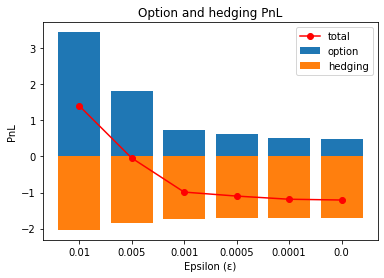

In [53]:
for col in plot_pnls_means[['option', 'hedging']]:
    plt.bar([str(i) for i in plot_pnls_means.index], plot_pnls_means[col], label=col)
plt.plot([str(i) for i in plot_pnls_means.index], plot_pnls_means.total, color='red', marker='o', label='total')
plt.legend()
plt.title('Option and hedging PnL')
plt.xlabel('Epsilon (ε)')
plt.ylabel('PnL')
plt.show()

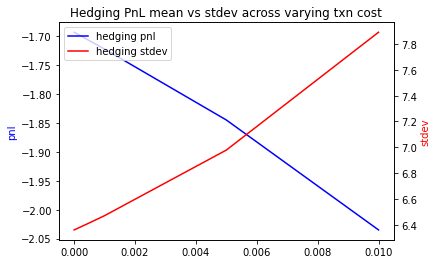

In [54]:
f, ax = plt.subplots()
a1, = ax.plot(plot_pnls_means.hedging, label='hedging pnl', color='blue')
ax.set_ylabel('pnl', color='blue')
ax2 = ax.twinx()
a2, = ax2.plot(plot_pnls_stds.hedging, label='hedging stdev', color='red')
ax2.set_ylabel('stdev', color='red')
plt.legend(handles=[a1, a2], loc='best')
plt.title('Hedging PnL mean vs stdev across varying txn cost')
plt.xlabel('Epsilon (ε)')
plt.show()

In [55]:
plot_pnls_stds.astype(float).round(2)

,total,option,hedging
0.0100,2.86,6.66,7.89
0.0050,1.98,6.66,6.98
0.0010,1.72,6.66,6.47
0.0005,1.72,6.66,6.41
0.0001,1.72,6.66,6.37
0.0000,1.72,6.66,6.36


In [56]:
plot_pnls_means.astype(float).round(2)

,total,option,hedging
0.0100,1.40,3.44,-2.03
0.0050,-0.04,1.80,-1.85
0.0010,-0.99,0.74,-1.72
0.0005,-1.10,0.61,-1.71
0.0001,-1.19,0.51,-1.70
0.0000,-1.21,0.49,-1.69


In [57]:
pd.DataFrame(index=epsilons, data={'txn only': eps_means, 'txn + mkt impact': eps_k_means})

,txn only,txn + mkt impact
0.0100,7.312121,7.379369
0.0050,5.730694,5.742341
0.0010,4.674061,4.675483
0.0005,4.549730,4.550410
0.0001,4.451238,4.451370
0.0000,4.426744,4.426744


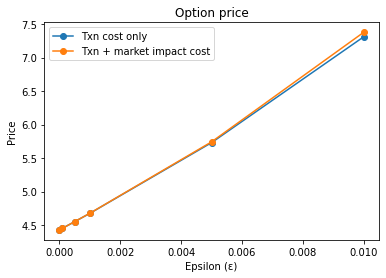

In [58]:
plt.plot(epsilons, eps_means, marker='o', label='Txn cost only')
plt.plot(epsilons, eps_k_means, marker='o', label='Txn + market impact cost')
plt.title('Option price')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Price')
plt.legend()
plt.show()

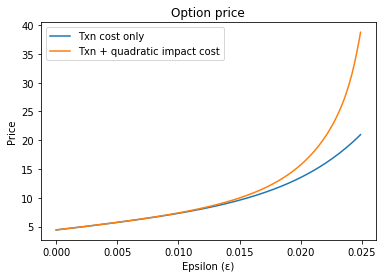

In [112]:
plt.plot(eps_plot, eps_means_plot, label='Txn cost only')
plt.plot(eps_plot, eps_means_k_plot, label='Txn + quadratic impact cost')
plt.title('Option price')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Price')
plt.legend()
plt.show()

## Market impact cost (square root)

In [60]:
y = 1
a_sq, Pi_sq, Pi_hat_sq = tools.get_pi_and_opt_hedge_txn(
    delta_S_hat, data_mat_t, S, delta_S,
    N_MC, n_steps, K, reg_param, gamma, option_type, sigma=sigma, epsilon=0, y=y
)
rewards_sq = tools.get_rewards_txn(Pi_sq, a_sq, delta_S, S, n_steps, risk_lambda, gamma=gamma, sigma=sigma, epsilon=0, y=y)
Q_sq = tools.get_q_function(
    data_mat_t, rewards_sq, Pi_sq,
    reg_param, gamma, n_steps, risk_lambda,
)
c_sq = -Q_sq

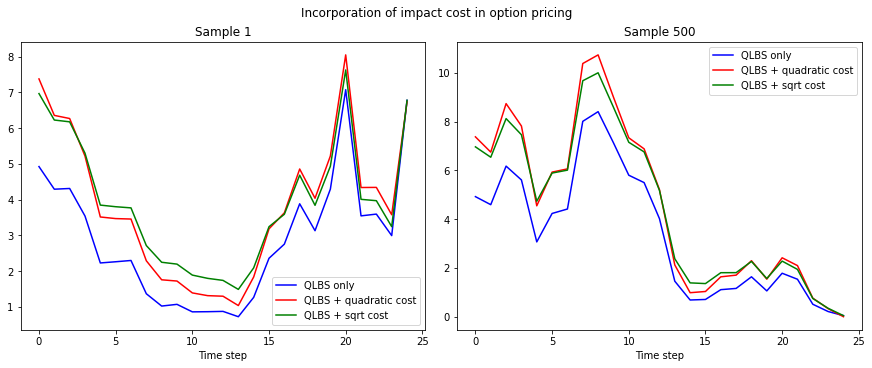

In [61]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plot_idx = [1, 500]

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(c_qlbs.loc[idx,:], label='QLBS only', color='blue')
    p1, = ax[i].plot(eps_k_prices[0.01].loc[idx,:], label='QLBS + quadratic cost', color='red')
    p2, = ax[i].plot(c_sq.loc[idx,:], label='QLBS + sqrt cost', color='green')
    ax[i].set_title(f'Sample {idx}')
    ax[i].legend(handles=[p0, p1, p2], loc='best')
    ax[i].set_xlabel('Time step')
plt.suptitle('Incorporation of impact cost in option pricing')
plt.show()

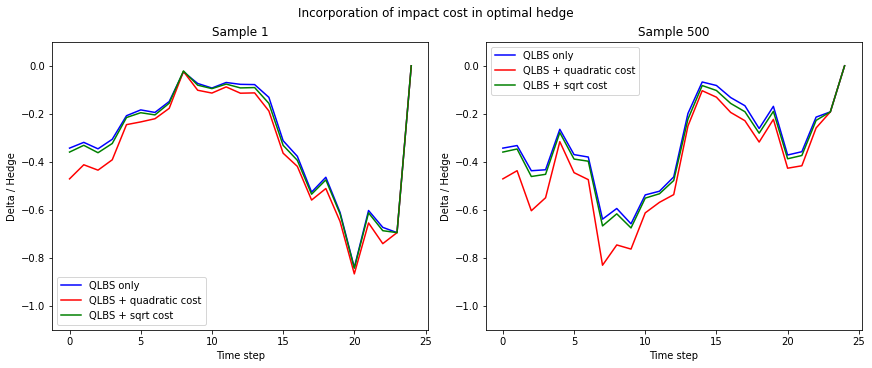

In [62]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(a.loc[idx,:], label='QLBS only', color='blue')
    p1, = ax[i].plot(eps_k_deltas[0.01].loc[idx,:], label='QLBS + quadratic cost', color='red')
    p2, = ax[i].plot(a_sq.loc[idx,:], label='QLBS + sqrt cost', color='green')
    ax[i].set_title(f'Sample {idx}')
    ax[i].set_ylabel('Delta / Hedge')
    ax[i].legend(handles=[p0, p1, p2], loc='best')
    ax[i].set_xlabel('Time step')
    if option_type=='call':
        ax[i].set_ylim([-0.1, 1.1])
    else:
        ax[i].set_ylim([-1.1, 0.1])
plt.suptitle('Incorporation of impact cost in optimal hedge')
plt.show()

In [63]:
h_pnl = {}
o_pnl = {}
t_pnl = {}
names = ['QLBS', 'QLBS + quadratic cost', 'QLBS + sqrt cost']
for name, p, d in zip(names, [
    c_qlbs, eps_k_prices[0.01], c_sq
], [
    a, eps_k_deltas[0.01], a_sq
]):
    h_pnl[name] = -tools.get_pnl(S, d, n_steps)
    o_pnl[name] = p.iloc[0,0] - p[n_steps]
    t_pnl[name] = o_pnl[name] + h_pnl[name].sum(axis=1)

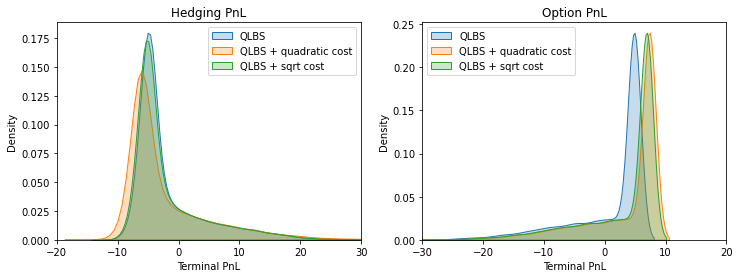

In [64]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for name in names:
    sns.kdeplot(h_pnl[name].sum(axis=1), shade=True, label=name, ax=ax[0])
    sns.kdeplot(o_pnl[name], shade=True, label=name, ax=ax[1])
ax[0].legend()
ax[0].set_title('Hedging PnL')
ax[0].set_xlim([-20, 30])
ax[0].set_xlabel('Terminal PnL')
ax[1].legend()
ax[1].set_title('Option PnL')
ax[1].set_xlim([-30, 20])
ax[1].set_xlabel('Terminal PnL')
plt.show()

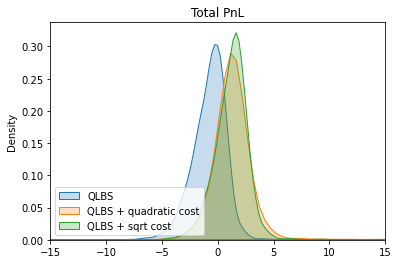

In [65]:
for name in names:
    sns.kdeplot(t_pnl[name], shade=True, label=name)
plt.legend(loc='lower left')
plt.xlim([-15,15])
plt.title('Total PnL')
plt.show()

In [66]:
pd.DataFrame(index=names, data={
    'Total': [t_pnl[name].mean() for name in t_pnl],
    'Option': [o_pnl[name].mean() for name in o_pnl],
    'Hedging': [h_pnl[name].sum(axis=1).mean() for name in h_pnl]
}).round(2)

,Total,Option,Hedging
QLBS,-0.75,0.94,-1.69
QLBS + quadratic cost,1.40,3.44,-2.03
QLBS + sqrt cost,1.23,2.98,-1.76


In [67]:
pd.DataFrame(index=names, data={
    'Total': [t_pnl[name].std() for name in t_pnl],
    'Option': [o_pnl[name].std() for name in o_pnl],
    'Hedging': [h_pnl[name].sum(axis=1).std() for name in h_pnl]
}).round(2)

,Total,Option,Hedging
QLBS,1.72,6.66,6.36
QLBS + quadratic cost,2.86,6.66,7.89
QLBS + sqrt cost,1.71,6.66,6.57


## Market impact cost (square root) (old)

In [94]:
# ys = [2, 1.5, 1, 0.5, 0.1, 0]
# y_deltas, y_prices = tools.vary_mkt_impact_cost_sqrt(
#     ys, delta_S_hat, data_mat_t, S, delta_S,
#     N_MC, n_steps, K, reg_param, gamma, option_type, sigma
# )

In [95]:
# for y in ys:
#     plt.plot(y_deltas[y].iloc[0], label=y)
# plt.legend(title='Y')
# plt.title('Optimal hedge a*')
# plt.xlabel('Time step')
# plt.show()

In [96]:
# for y in ys:
#     plt.plot(y_prices[y].iloc[0], label=y)
# plt.legend(title='Y')
# plt.title('Option price')
# plt.xlabel('Time step')
# plt.show()

In [97]:
# y_means = [y_prices[y].iloc[0,0] for y in ys]
# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
# ax[0].plot(ys, y_means, marker='o', label='QLBS')
# ax[0].axhline(y=bsm_price.iloc[0,0], color='red', ls='--', label='BSM')
# ax[0].set_xlabel('Y')
# ax[0].set_ylabel('Initial option price')
# ax[0].set_title('QLBS Market impact cost vs BSM price')
# ax[0].legend()

# premiums = [j-bsm_price.iloc[0,0] for j in y_means[::-1]]
# colors = ['g' if p >= 0 else 'r' for p in premiums]
# ax[1].bar([str(i) for i in ys[::-1]], premiums, color=colors)
# ax[1].set_xlabel('Y')
# ax[1].set_ylabel('Premium')
# ax[1].set_title('QLBS premium/discount for market impact cost')
# plt.show()

In [98]:
# y_plot = np.arange(0, 2, 0.01)
# y_deltas_plot, y_prices_plot = tools.vary_mkt_impact_cost_sqrt(
#     y_plot, delta_S_hat, data_mat_t, S, delta_S,
#     N_MC, n_steps, K, reg_param, gamma, option_type, sigma=sigma, print_line=False
# )
# y_means_plot = [y_prices_plot[y].iloc[0,0] for y in y_plot]
# premiums = [j-bsm_price.iloc[0,0] for j in y_means_plot[::-1]]
# plt.plot(y_plot, y_means_plot)
# plt.show()

## Fitted Q Iteration
- on-policy data: contains optimal action and corresponding reward
- off-policy data: contains random action and corresponding reward
  
- ideally as N_MC tends to infinity, random becomes optimal
- over here, random = optimal + noise (sampled from uniform distr)

$$
a_t(X_T) = a^*_t(X_T) \sim U[1-\eta, 1+\eta]
$$

In [73]:
eta = 0.5

In [74]:
a_fqi, Pi_fqi, Pi_hat_fqi, rewards_fqi = tools.get_perturbated_hedge(
    delta_S_hat, data_mat_t, S, delta_S, a,
    N_MC, n_steps, K, reg_param, gamma, option_type, eta, risk_lambda,
)

In [75]:
psi_mat, s_t_mat= tools.init_matrices(a_fqi, data_mat_t, N_MC, n_steps)

In [76]:
q_fqi, a_star_fqi = tools.get_fqi(
    psi_mat, s_t_mat, data_mat_t, Pi_fqi, rewards_fqi, delta_S_hat, Pi_hat_fqi,
    0, N_MC, n_steps, reg_param, gamma
)
c_fqi = -q_fqi

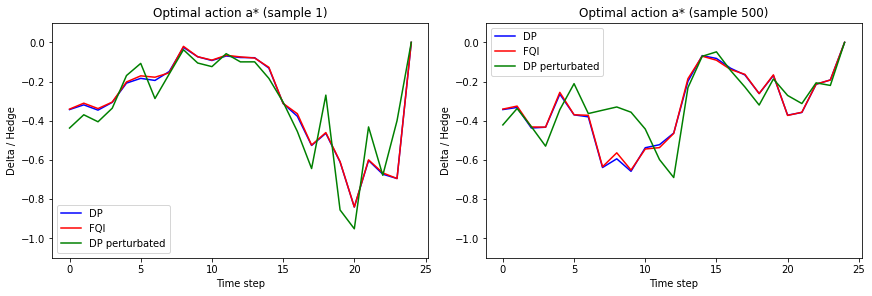

In [89]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(a.loc[idx,:], label='DP', color='blue')
    p1, = ax[i].plot(a_star_fqi.loc[idx,:], label='FQI', color='red')
    p2, = ax[i].plot(a_fqi.loc[idx,:], label='DP perturbated', color='green')
    ax[i].set_title(f'Optimal action a* (sample {idx})')
    ax[i].set_ylabel('Delta / Hedge')
    ax[i].legend(handles=[p0, p1, p2], loc='best')
    ax[i].set_xlabel('Time step')
    if option_type=='call':
        ax[i].set_ylim([-0.1, 1.1])
    else:
        ax[i].set_ylim([-1.1, 0.1])

In [87]:
print(f'FQI\t{c_fqi.iloc[0,0]:.4f}')
print(f'DP\t{c_qlbs.iloc[0,0]:.4f}')

FQI	4.9818
DP	4.9261


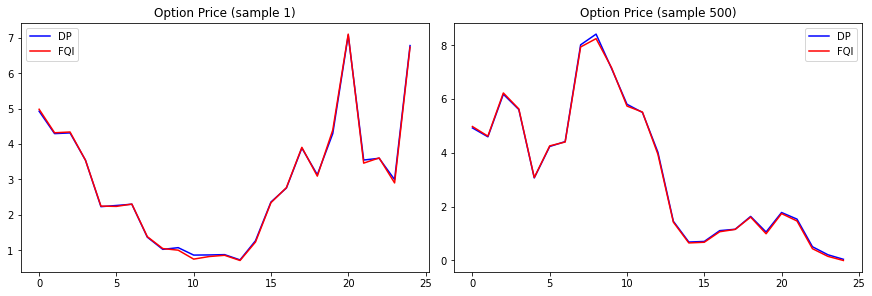

In [92]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

for i, idx in enumerate(plot_idx):
    p0, = ax[i].plot(c_qlbs.loc[idx,:], label='DP', color='blue')
    p1, = ax[i].plot(c_fqi.loc[idx,:], label='FQI', color='red')
    ax[i].set_title(f'Option Price (sample {idx})')
    ax[i].legend(handles=[p0, p1], loc='best')

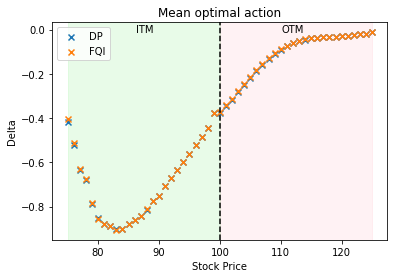

In [91]:
tools.plot_mean_curve(S, K, a, a_star_fqi, option_type, 'delta', title='Mean optimal action', l1='DP', l2='FQI')